# Project 2

In [ ]:
import os 
from getpass import getpass
import urllib

user = 'muhammad-ali-sabtain'
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/monmouth-college-cs/data240s21-proj2-team2.git

GitHub password··········
Cloning into 'data240s21-proj2-team2'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 3), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


Libraries Imported


In [ ]:
import re
import pandas as pd
import itertools 
import numpy as np
!pip install -U yellowbrick
import nltk
import os
import codecs
from sklearn import feature_extraction
#import mpld3
import matplotlib.pyplot as plt

Requirement already up-to-date: yellowbrick in /usr/local/lib/python3.7/dist-packages (1.3.post1)


Splitting Data Set

In [ ]:
with open('data240s21-proj2-team2/articles.txt', 'r') as f:
  fulltext = f.read()

After importing the text articles the first thing to do is to seperate by Document ID: 
One thing that had to be considered when doing this was that after the colon the was a series of numbers and letters that were all different. In order to split the text while taking these series of numbers and letters into consideration the .+ was used since all of the Document ID'S ended in a . 

In [ ]:
split_text = re.split('Document ID:.+',fulltext)
print(len(split_text))
print(split_text[-1])
split_text.pop()
print(len(split_text))

2226





2225


In the end we had 2225 articles.
In the following code the text articles were split into seperate lines of Topic, Title, Subheading, and Body. 
After splitting the data we then took all of the split articles into a dataframe to organzize them and having and column for Topic, Title, Subheading, and Body 


In [ ]:
def split_article(text):
    metadata, body = re.split('--- ---', article.strip(),maxsplit=1)
    spdata=metadata.split('\n')
    topic = spdata[0].split(':')
    title = spdata[1].split(':')
    subhead = spdata[2].split(':')
    return int(topic[1].strip()), title[1].strip(), subhead[1].strip(), body.strip()
       

df = pd.DataFrame(columns=['Topic', 'Title','Subheading', 'Body'])
i = 0
for article in split_text:
    topic, title, subhead, body = split_article(article)
    assert type(topic) is int
    df.loc[i] = [topic, title, subhead, body]
    i += 1

df['Topic'] = df['Topic'].apply(int)
df.dtypes

Topic          int64
Title         object
Subheading    object
Body          object
dtype: object

Topic in the dataframe was not considered an integer and so that had to be changed for future use when running the K-Means clustering. 


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(stop_words=('english'),max_df=.5)
vectorized_body = vectorizer.fit_transform(df['Body'])



Based on the original Dataframe we took the vectorized body in order to classify the data. 
A Random Forest Classifier was used to determine how well the Topic can be predicted based on the body of the articles 

In [ ]:
X, y =  vectorized_body, df['Topic']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
RFclass=classifier.fit(X_train, y_train)
RFclass.score(X_test,y_test)

0.9707865168539326

The Random Forest Classifier had an accuracy of 97%. This shows that it was highly accurate when predicting topic based off the body of an article.

When thinking about the vectorized body visually by putting the datapoints in some space the best way to think is that is is a very big mutlidimensional space that would be very hard to plot because of how many dimensions are within it. 
In order to get a better idea of how this data can be seen visually a PCA (Principal Compoenent Analysis) of the vectorized body is done to turn it into a 2-D Space.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


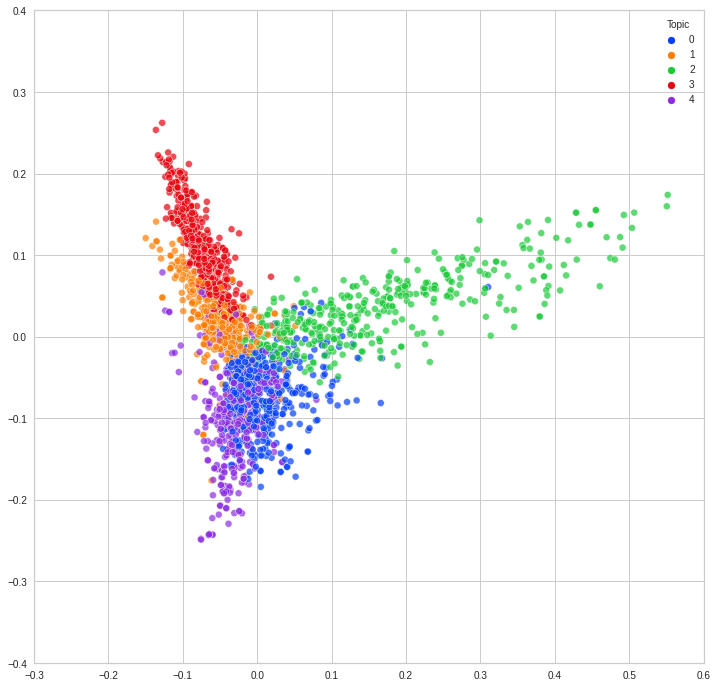

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca=PCA(n_components=2)

fig=plt.figure(figsize=(12,12))

plt.xlim(-.3,.6)
plt.ylim(-.4,.4)

v_pca=pca.fit_transform(vectorized_body.toarray())


sns.scatterplot(v_pca[:,0],v_pca[:,1],hue=df['Topic'], alpha=0.7, palette='bright')

Looking the result from the PCA it can be seen that each Topic is is within its own cluster of points, but the one that is fairly spaced out is Topic 2. 
It seems like Topic 0 and Topic 4 intersect a lot.
It can also be seen that all Topics have some similarities in articles since they seem to meet at the Origin (0,0)
From this a K-Means cluster Analysis will be done to see how similar are the articles for Topic 0 and if there are any big differences within clusters of that specific Topic.
Later a K-Means cluster Analysis will be done on Topic 2 since it is the most spread out Topic and could potentially have some varying clusters.

# Topic 0

In the code below we have a dataframe that solely takes articles from Topic 0.
Here we took the Body of the articles from the dataframe T0_df and vectorized them to prepare the body to be used in the K-Means clustering for a Data Analysis.

In [ ]:
array = ['0']
T0_df = df.loc[df['Topic'].isin(array)]

,Topic,Title,Subheading,Body
1,0,US economy shows solid GDP growth,"The US economy has grown more than expected, e...",The gross domestic product figure was ahead of...
2,0,S Korean credit card firm rescued,South Korea's largest credit card firm has ave...,LG Card had been threatened with collapse beca...
11,0,China keeps tight rein on credit,China's efforts to stop the economy from overh...,The curbs were introduced earlier this year to...
15,0,Standard Life concern at LSE bid,Standard Life is the latest shareholder in Deu...,It said Deutsche Boerse had to show why its pl...
16,0,Yukos loses US bankruptcy battle,A judge has dismissed an attempt by Russian oi...,Yukos filed for Chapter 11 protection in Houst...
...,...,...,...,...
2194,0,Qantas considers offshore option,Australian airline Qantas could transfer as ma...,Chief executive Geoff Dixon was quoted by The ...
2204,0,Air Jamaica back in state control,The Jamaican government is regaining control o...,The firm has failed to make money since the st...
2216,0,Boeing unveils new 777 aircraft,US aircraft firm Boeing has unveiled its new l...,The 777-200LR will be capable of flying almost...
2221,0,German growth goes into reverse,Germany's economy shrank 0.2% in the last thre...,The figures confounded hopes of a 0.2% expansi...


In [ ]:
vectorizer=TfidfVectorizer(stop_words=('english'),max_df=.5,max_features=50)
vectorized_body_T0 = vectorizer.fit_transform(T0_df['Body'])
indices=np.argsort(vectorizer.idf_)
features=vectorizer.get_feature_names()
top_n=50
top_features=[features[i] for i in indices[:top_n]]


feature_names = vectorizer.get_feature_names()
dense = vectorized_body_T0.todense()
denselist = dense.tolist()
df_vect = pd.DataFrame(denselist, columns = top_features)
df_vect_top=df_vect[top_features].copy()
df_vect_top

,new,market,mr,company,firm,growth,years,2004,chief,expected,analysts,government,world,economy,business,economic,000,time,months,companies,financial,shares,2005,2003,bank,told,rise,month,state,group,prices,december,sales,demand,firms,oil,investment,deal,country,people,uk,president,rate,quarter,european,countries,dollar,tax,china,yukos
0,0.000000,0.000000,0.187199,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.117854,0.000000,0.000000,0.000000,0.000000,0.204832,0.101450,0.000000,0.193261,0.000000,0.000000,0.0,0.098081,0.000000,0.185094,0.000000,0.000000,0.110622,0.000000,0.000000,0.081766,0.000000,0.000000,0.0,0.000000,0.739566,0.366681,0.329532,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.093070,0.000000
1,0.000000,0.000000,0.000000,0.0,0.000000,0.172799,0.000000,0.000000,0.000000,0.000000,0.402273,0.0,0.187993,0.185814,0.000000,0.000000,0.000000,0.000000,0.161826,0.000000,0.000000,0.171621,0.725897,0.0,0.000000,0.177719,0.000000,0.000000,0.267500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.175216,0.000000,0.000000,0.148459,0.000000
2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.688377,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.144206,0.167845,0.129692,0.128469,0.000000,0.000000,0.000000,0.000000,0.0,0.124202,0.000000,0.351585,0.147513,0.000000,0.000000,0.000000,0.000000,0.000000,0.147513,0.000000,0.0,0.282172,0.000000,0.309559,0.000000,0.143674,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.255337,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.255452,0.234944,0.000000,0.000000,0.211006,0.0,0.000000,0.000000,0.282708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.228455,0.0,0.000000,0.000000,0.000000,0.292398,0.420939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.270063,0.000000,0.000000,0.0,0.000000,0.606042,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.066071,0.147264,0.069174,0.127241,0.000000,0.071673,0.057138,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083781,0.000000,0.073130,0.000000,0.0,0.133332,0.075729,0.000000,0.000000,0.000000,0.000000,0.000000,0.057138,0.000000,0.079178,0.000000,0.0,0.000000,0.000000,0.000000,0.074662,0.000000,0.000000,0.075458,0.091439,0.0,0.074662,0.000000,0.000000,0.063260,0.932712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,0.508537,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.460322,0.000000,0.000000,0.000000,0.0,0.000000,0.286445,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.412370,0.000000,0.000000,0.206711,0.402127,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.270107,0.000000,0.000000,0.000000,0.000000
506,0.439537,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.357327,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.431236,0.000000,0.000000,0.000000,0.386876,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.347565,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.471896,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
507,0.173682,0.363911,0.157215,0.0,0.163271,0.000000,0.000000,0.000000,0.000000,0.000000,0.282393,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.207036,0.162306,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.140837,0.000000,0.175378,0.423589,0.274679,0.000000,0.200323,0.0,0.000000,0.207036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.169339,0.468977,0.000000
508,0.000000,0.163865,0.283168,0.0,0.

Below is the K-Means cluster Analysis for Topic 0. 
Due to the randomness of K-Means Cluster anaylsis in terms of initial centroids random_state is used to be consistent on each run instead of changes in terms of results of the clusters. 
The elbow Method is used to help identify the number of clusters within Topic 0. Based on the resutls it seems that 6 would be a good number for the number of clsuters. 

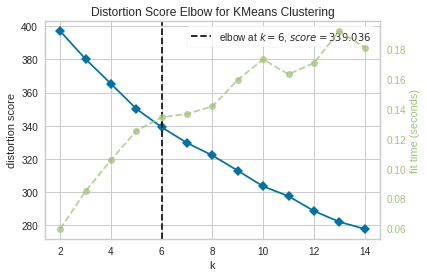

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3b65711490>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=14,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto', random_state=4,
                                  tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='distortion', timings=True)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from yellowbrick.cluster import kelbow_visualizer

dist = 1 - cosine_similarity(df_vect_top)
#for k-means clustering 
number_cluster= 6
km = KMeans(n_clusters=number_cluster, random_state=7).fit(df_vect_top)


X = df_vect_top
kelbow_visualizer(KMeans(random_state=4), X, k=(2,15))
## usiung the Elbow Method we can visually see the best choice for K and in this case it seens that 5 is the best choice



In [ ]:
km.cluster_centers_
T0_df.insert(1,"Cluster",km.labels_,True)
T0_df


,Topic,Cluster,Title,Subheading,Body
1,0,1,US economy shows solid GDP growth,"The US economy has grown more than expected, e...",The gross domestic product figure was ahead of...
2,0,0,S Korean credit card firm rescued,South Korea's largest credit card firm has ave...,LG Card had been threatened with collapse beca...
11,0,1,China keeps tight rein on credit,China's efforts to stop the economy from overh...,The curbs were introduced earlier this year to...
15,0,0,Standard Life concern at LSE bid,Standard Life is the latest shareholder in Deu...,It said Deutsche Boerse had to show why its pl...
16,0,3,Yukos loses US bankruptcy battle,A judge has dismissed an attempt by Russian oi...,Yukos filed for Chapter 11 protection in Houst...
...,...,...,...,...,...
2194,0,0,Qantas considers offshore option,Australian airline Qantas could transfer as ma...,Chief executive Geoff Dixon was quoted by The ...
2204,0,0,Air Jamaica back in state control,The Jamaican government is regaining control o...,The firm has failed to make money since the st...
2216,0,4,Boeing unveils new 777 aircraft,US aircraft firm Boeing has unveiled its new l...,The 777-200LR will be capable of flying almost...
2221,0,1,German growth goes into reverse,Germany's economy shrank 0.2% in the last thre...,The figures confounded hopes of a 0.2% expansi...


A Silhouette plot is used to see how well the data was clustered by measuring the distance of each data point to the centroid of its cluster and comparing it with the distances to the other centroids. 
One thing to note is when working with text data sometimes the Silhouette plot might not show that much importance since text data in general can be hard to cluster as shown below. 
A silhouette plot was created to see results with different K, but still not very useful and so 6 was still the final number used for Topic 0.

For n_clusters = 5 The average silhouette_score is : 0.07936517524833066
For n_clusters = 6 The average silhouette_score is : 0.08237602133455073
For n_clusters = 7 The average silhouette_score is : 0.09195390071448444


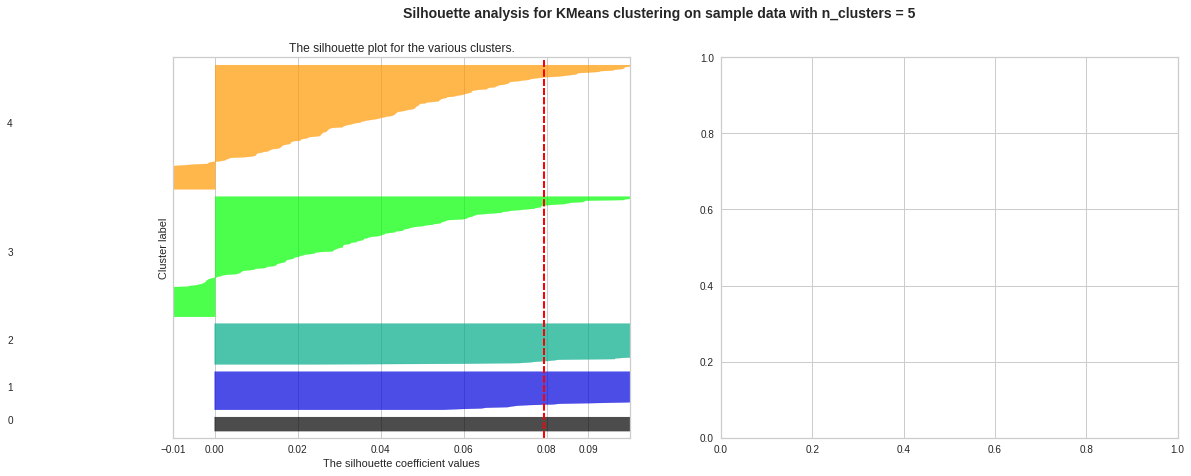

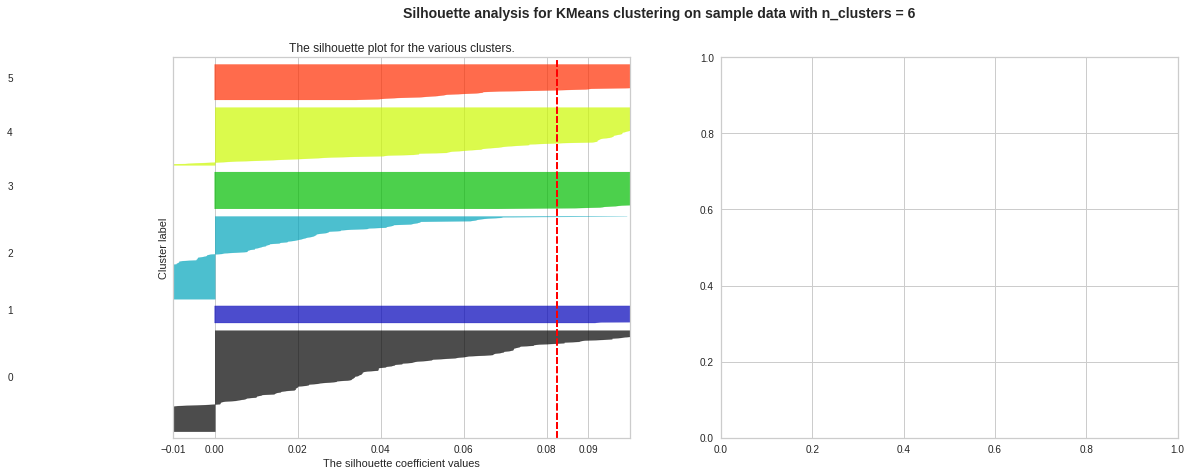

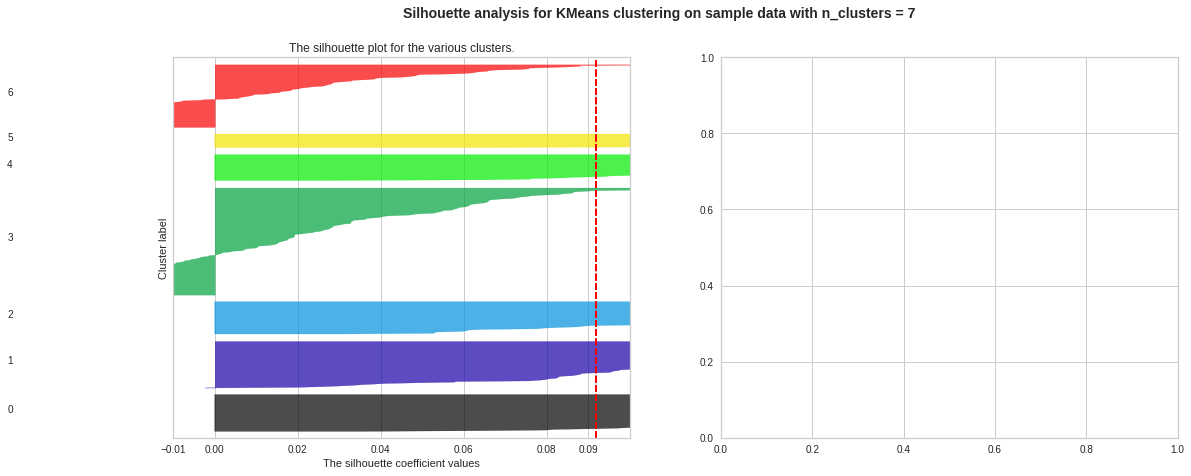

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [5,6,7]
for n_clusters in range_n_clusters:
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)
  ax1.set_xlim([-0.01, .1])
  ax1.set_ylim([0,df_vect_top.shape[0] + (n_clusters + 1) * 10])
  clusterer = KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict(df_vect_top)
  silhouette_avg = silhouette_score(df_vect_top, cluster_labels)
  print("For n_clusters =", n_clusters,
  "The average silhouette_score is :", silhouette_avg)
  sample_silhouette_values = silhouette_samples(df_vect_top, cluster_labels)
  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = \
      sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.01, 0, 0.02, 0.04, 0.06, 0.08,.09 ])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  # ax2.scatter(vectorized_body_T0[:, 0], vectorized_body_T0[:, 1], marker='.', s=30, lw=0, alpha=0.7,c= colors, edgecolor='k')
   # centers = clusterer.cluster_centers_
   # ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')
    #for i, c in enumerate(centers):
     #   ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
         #           s=50, edgecolor='k')
    #ax2.set_title("The visualization of the clustered data.")
   # ax2.set_xlabel("Feature space for the 1st feature")
   # ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

In [ ]:

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(number_cluster):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :5]: #replace 6 with n words per cluster
        # This is how to debug:
        feat = top_features[ind]
        print(feat)
    
print()


Top terms per cluster:

Cluster 0 words:analysts
president
2005
economy
state
Cluster 1 words:rise
months
time
000
investment
Cluster 2 words:uk
mr
analysts
business
deal
Cluster 3 words:yukos
demand
quarter
rate
analysts
Cluster 4 words:december
analysts
sales
countries
years
Cluster 5 words:bank
firms
government
world
2003



The top 5 words in each cluster were identified and then printed to then create a visual representaiton of the K-Means cluster Analysis. 
Based on the key words they seem to all be fairly similar in that Topic 0 seems to be mainly business and economics. 
The most common words used are Analysts and business. 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  

xs, ys = pos[:, 0], pos[:, 1]


In [ ]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#e377c2'}

#set up cluster names using a dict
cluster_names = {0: 'analysts, president, economy, state', 
                 1: 'rise, months, time, investment', 
                 2: 'uk, analysts, business, deal', 
                 3: 'yukos, demand, quarter, rate', 
                 4: 'december, analysts, sales, countries',
                 5: 'bank, firms, government, world'
                 }

Both these chunks of code will be used for placement of the datapoints in a 2-D space

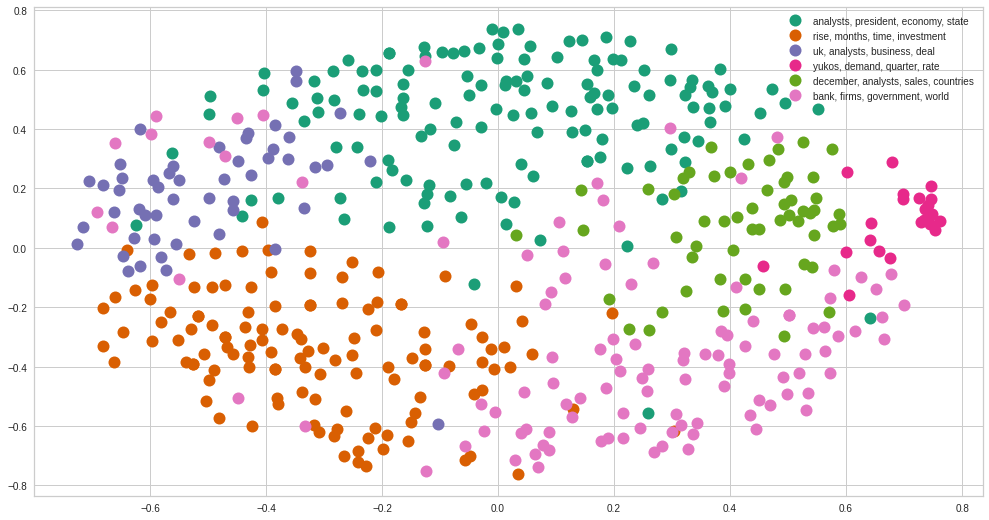

In [ ]:
%matplotlib inline 
clusters = km.labels_.tolist()
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label = cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point
    
    
plt.show() #show the plot

Based on the results Cluster 4 seems to be the only cluster thats clumped together. The other clusters do seem to intersect with each other a bit except for Cluster 2 and 3. Those seem to be clustered fairly well unlike cluster of 6, which seemed to have datapoints scattered everywhere.

# Topic 2

In [ ]:
array = ['2']
T2_df = df.loc[df['Topic'].isin(array)]
T2_df

,Topic,Title,Subheading,Body
5,2,UK firms 'embracing e-commerce',UK firms are embracing internet trading opport...,A government-commissioned study ranked the UK ...
13,2,Defection timed to hit tax pledge,With impeccable and precisely-calculated timin...,With just about everyone in Westminster now wo...
21,2,Blair backs 'pre-election budget',Tony Blair has backed Chancellor Gordon Brown'...,"In a speech in Edinburgh, the prime minister s..."
22,2,Blair joins school sailing trip,The prime minister has donned a life jacket an...,Tony Blair sailed across the lake in Bromsgrov...
24,2,Blair backs 'pre-election budget',Tony Blair has backed Chancellor Gordon Brown'...,"In a speech in Edinburgh, the prime minister s..."
...,...,...,...,...
2196,2,Blair dismisses quit claim report,Tony Blair has dismissed reports he told Gordo...,"""You don't do deals over jobs like this,"" the ..."
2203,2,Analysis,"He called it his ""masochism strategy"" in the r...",The idea is simple - the prime minister goes h...
2211,2,Borders rail link campaign rally,Campaigners are to stage a rally calling for a...,They will mark the 36th anniversary of the lin...
2215,2,Blair rejects Tory terror offer,Tony Blair has rejected a Conservative comprom...,The Tories wanted a sunset clause inserted in ...


Now a dataframe containing only containing articles from Topic 2 to then have each body vecotrized to be used for the K-Means clustering. 

In [ ]:
vectorizer2=TfidfVectorizer(stop_words=('english'),max_df=.5,max_features=50)
vectorized_body_T2 = vectorizer2.fit_transform(T2_df['Body'])
indices2=np.argsort(vectorizer2.idf_)
features2=vectorizer2.get_feature_names()
top_n2=50
top_features2=[features2[i] for i in indices[:top_n2]]


feature_names2 = vectorizer2.get_feature_names()
dense2 = vectorized_body_T2.todense()
denselist2 = dense2.tolist()
df_vect2 = pd.DataFrame(denselist2, columns = top_features2)
df_vect_top2=df_vect2[top_features2].copy()
df_vect_top2

,prime,new,police,election,like,minister,year,bbc,campaign,lib,britain,lord,work,law,brown,labour,000,uk,plans,country,liberal,told,blair,added,british,want,think,party,tories,make,secretary,howard,time,issue,local,public,mps,home,going,say,way,says,tax,spokesman,leader,general,just,tory,chancellor,years
0,0.144551,0.129364,0.000000,0.000000,0.000000,0.148714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.111275,0.000000,0.129813,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.944949,0.000000,0.000000,0.000000,0.000000,0.134503
1,0.000000,0.059199,0.055018,0.053809,0.000000,0.000000,0.000000,0.000000,0.070099,0.000000,0.206151,0.060244,0.134443,0.000000,0.398480,0.000000,0.061551,0.142860,0.000000,0.000000,0.000000,0.000000,0.067496,0.000000,0.0,0.000000,0.000000,0.000000,0.050921,0.101843,0.000000,0.0,0.000000,0.107618,0.056281,0.000000,0.000000,0.000000,0.773250,0.000000,0.231981,0.000000,0.127270,0.185325,0.000000,0.000000,0.062690,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.180617,0.176648,0.097510,0.000000,0.481324,0.112172,0.460255,0.000000,0.169192,0.098887,0.110341,0.000000,0.000000,0.000000,0.000000,0.234496,0.000000,0.000000,0.000000,0.102901,0.000000,0.000000,0.0,0.189749,0.077944,0.119776,0.000000,0.000000,0.097510,0.0,0.096837,0.176648,0.000000,0.000000,0.000000,0.000000,0.380773,0.000000,0.000000,0.248521,0.000000,0.000000,0.101400,0.000000,0.102901,0.111707,0.088324,0.000000
3,0.118139,0.000000,0.000000,0.672702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.460221,0.215185,0.240110,0.000000,0.000000,0.000000,0.000000,0.255141,0.000000,0.000000,0.134710,0.111961,0.000000,0.130321,0.0,0.000000,0.084806,0.130321,0.000000,0.000000,0.106095,0.0,0.105362,0.000000,0.100516,0.000000,0.197788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096100,0.000000
4,0.000000,0.000000,0.180617,0.176648,0.097510,0.000000,0.481324,0.112172,0.460255,0.000000,0.169192,0.098887,0.110341,0.000000,0.000000,0.000000,0.000000,0.234496,0.000000,0.000000,0.000000,0.102901,0.000000,0.000000,0.0,0.189749,0.077944,0.119776,0.000000,0.000000,0.097510,0.0,0.096837,0.176648,0.000000,0.000000,0.000000,0.000000,0.380773,0.000000,0.000000,0.248521,0.000000,0.000000,0.101400,0.000000,0.102901,0.111707,0.088324,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,0.000000,0.000000,0.157309,0.461556,0.113235,0.000000,0.558947,0.000000,0.133620,0.126594,0.098239,0.057417,0.000000,0.065131,0.063297,0.063045,0.000000,0.045385,0.000000,0.054354,0.000000,0.059748,0.192988,0.000000,0.0,0.110175,0.316797,0.000000,0.097064,0.048532,0.056618,0.0,0.337360,0.051284,0.000000,0.063808,0.052775,0.000000,0.000000,0.131914,0.055274,0.192400,0.000000,0.058877,0.058877,0.000000,0.119496,0.000000,0.051284,0.000000
413,0.000000,0.065101,0.000000,0.473385,0.000000,0.074839,0.080616,0.375750,0.000000,0.000000,0.340054,0.000000,0.147846,0.000000,0.073034,0.072744,0.000000,0.261836,0.000000,0.000000,0.000000,0.068939,0.074225,0.080245,0.0,0.063562,0.208875,0.160489,0.000000,0.000000,0.000000,0.0,0.324381,0.355039,0.000000,0.220872,0.000000,0.000000,0.000000,0.076103,0.063777,0.110998,0.000000,0.000000,0.000000,0.000000,0.068939,0.000000,0.000000,0.067687
414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.920553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.390618,0.000000,0.000000,0.000000,0.

Like the K-Means cluster before the Elbow method was used to determined the best number of clusters and the best one seems to be 7. 

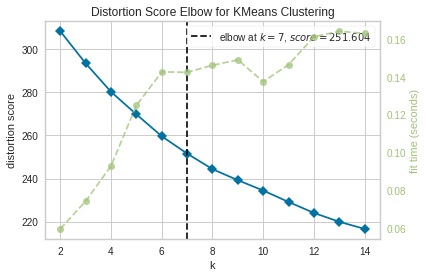

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3b53277fd0>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=14,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto', random_state=4,
                                  tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='distortion', timings=True)

In [ ]:
dist2 = 1 - cosine_similarity(df_vect_top2)
#for k-means clustering 
number_cluster2= 7
km2 = KMeans(n_clusters=number_cluster2, random_state=7).fit(df_vect_top2)


X2 = df_vect_top2
kelbow_visualizer(KMeans(random_state=4), X2, k=(2,15))
## usiung the Elbow Method we can visually see the best choice for K and in this case it seens that 5 is the best choice

In [ ]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids2 = km2.cluster_centers_.argsort()[:, ::-1] 

for i in range(number_cluster2):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids2[i, :6]: #replace 6 with n words per cluster
        # This is how to debug:
        feat = top_features2[ind]
        print(feat)
    
print()

Top terms per cluster:

Cluster 0 words:leader
minister
like
law
mps
home
Cluster 1 words:election
think
brown
time
uk
says
Cluster 2 words:year
campaign
uk
britain
election
time
Cluster 3 words:british
plans
says
police
campaign
lord
Cluster 4 words:prime
chancellor
added
tory
tories
issue
Cluster 5 words:make
uk
britain
brown
going
tax
Cluster 6 words:howard
plans
law
mps
tories
says



The key words for the clusters in Topic 2 seem to be about politics and government. 
For the most part all the clusters didn't seem to have any significant different in key words or importance. 

---



In [ ]:
km2.cluster_centers_
T2_df.insert(1,"Cluster2",km2.labels_,True)

In [ ]:
dist2 = 1 - cosine_similarity(df_vect_top2)
MDS()

mds2 = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos2 = mds2.fit_transform(dist2)  

xs2, ys2 = pos2[:, 0], pos2[:, 1]

In [ ]:
cluster_colors2 = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#e377c2',6:'#bcbd22'}

#set up cluster names using a dict
cluster_names2 = {0: 'leader, minister, like, law', 
                 1: 'election, think, brown, time', 
                 2: 'year, campaign, uk, britain', 
                 3: 'british, plans, police, campaign', 
                 4: 'prime, chancellor, added, tory',
                 5: 'make, uk, britain, brown',
                 6: 'howard, plans, law, mps'
                 }

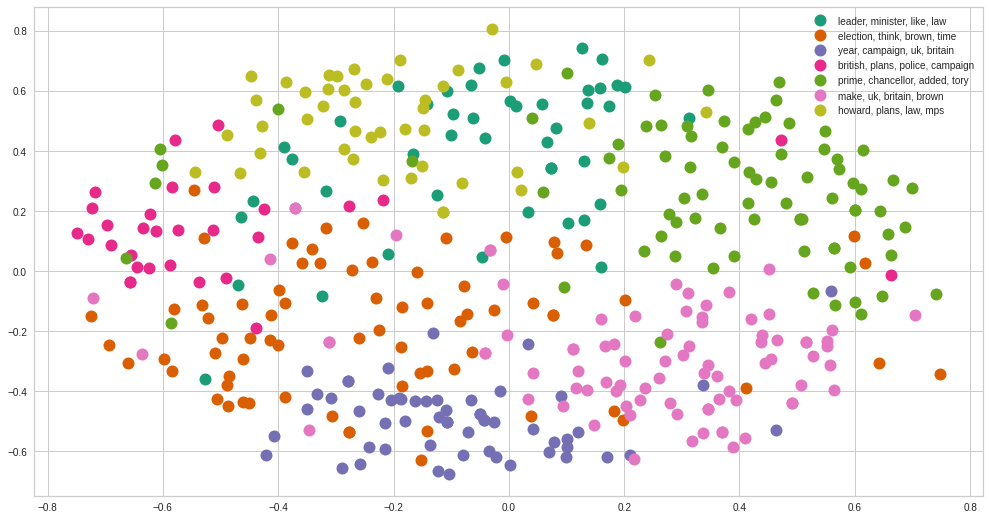

In [ ]:
clusters2 = km2.labels_.tolist()
df2 = pd.DataFrame(dict(x=xs, y=ys, label=clusters2)) 
#group by cluster
groups2 = df2.groupby('label')


# set up plot
fig2, ax2 = plt.subplots(figsize=(17, 9)) # set size
ax2.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups2:
    ax2.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names2[name], color=cluster_colors2[name], 
            mec='none')
    ax2.set_aspect('auto')
    ax2.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax2.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax2.legend(numpoints=1)  #show legend with only 1 point
    
    
plt.show() #show the plot

Topic 2 seemed to have some better clustering compared to Topic 0, but certain clusters still had some points scattered everywhere. 
The best clusters seemed to be Cluster 3,5,and 6